# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.utils.data as data_utils
import os
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.preprocessing import StandardScaler

from metaimnet import *

## Set Inputs

In [2]:
seed = 7               # Set seed. Keep this constant for reproducibility.
n_samples = 10000      # How many samples do we keep for training + validation (rest will be used for testing)
num_metaims = 5        # How many meta-IMs do we want to extract from the hazard time history?

In [3]:
path_to_predictor_dataset = '../RC_Frame_large/predictors.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_processed_time_histories = '../RC_Frame_large/x_gm'                  # Set the path to your ground motions file

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'tip_displacement']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')

# Eliminate Outliers
predictors_all = predictors_all[predictors_all['tip_displacement']<48].reset_index(drop = True)

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

We assume the collapse capacity of the building to be 12 inches

In [5]:
capacity = 12
predictors_all['capacity'] = capacity
predictors_all['damage_state'] = 0

predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

## Prepare training data

In [6]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
cols_predicted = ['damage_state']

x_train_scaled, x_val_scaled, x_test_scaled, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                                                  val_data, 
                                                                                                  test_data, 
                                                                                                  cols2scale)


## Prepare ground motion features

In [7]:
x_th_all = torch.load(path_to_processed_time_histories)

In [8]:
train_data, val_data, test_data, x_th, x_th_val, x_th_test = split_ground_motions(x_th_all, 
                                                                                  train_data, 
                                                                                  val_data, 
                                                                                  test_data)

In [9]:
del x_th_all

## Train Meta-IMNet

In [10]:
max_epochs = 500
interval = 50

start = timeit.default_timer()
model1, model2, error_evolution_training, error_evolution_val = train_metaimnet_model(x_train_scaled, 
                                                                                   x_val_scaled, 
                                                                                   y_data, 
                                                                                   y_val, 
                                                                                   x_th, 
                                                                                   x_th_val, 
                                                                                   train_data, 
                                                                                   val_data, 
                                                                                   cols2scale,
                                                                                   num_metaims,
                                                                                   max_epochs,
                                                                                   interval,
                                                                                   seed)

stop = timeit.default_timer()

print('Time Elapsed in Model Training: ', stop - start)

Epoch 1: Training BCE Loss 0.8408, Validation BCE Loss 0.8378
Epoch 50: Training BCE Loss 0.8094, Validation BCE Loss 0.8109
Epoch 100: Training BCE Loss 0.7151, Validation BCE Loss 0.7069
Epoch 150: Training BCE Loss 0.6076, Validation BCE Loss 0.6022
Epoch 200: Training BCE Loss 0.5138, Validation BCE Loss 0.5117
Epoch 250: Training BCE Loss 0.4490, Validation BCE Loss 0.4618
Epoch 300: Training BCE Loss 0.4041, Validation BCE Loss 0.4379
Epoch 350: Training BCE Loss 0.3674, Validation BCE Loss 0.4154
Epoch 400: Training BCE Loss 0.3434, Validation BCE Loss 0.4131
Epoch 450: Training BCE Loss 0.3300, Validation BCE Loss 0.4162
Epoch 500: Training BCE Loss 0.3237, Validation BCE Loss 0.4218
Time Elapsed in Model Training:  730.2977610188536


In [11]:
y_pred_train = predict_metaimnet(model1, model2, x_th, x_train_scaled, train_data)
y_pred_val = predict_metaimnet(model1, model2, x_th_val, x_val_scaled, val_data)

train_data['damage_state_pred'] = y_pred_train.detach().view(-1).numpy()
train_data['damage_state_class_pred'] = train_data['damage_state_pred'].round().astype("int")

val_data['damage_state_pred'] = y_pred_val.detach().view(-1).numpy()
val_data['damage_state_class_pred'] = val_data['damage_state_pred'].round().astype("int")

## Distribution of responses

,Survived,Failed
Survived,0.926471,0.073529
Failed,0.048246,0.951754


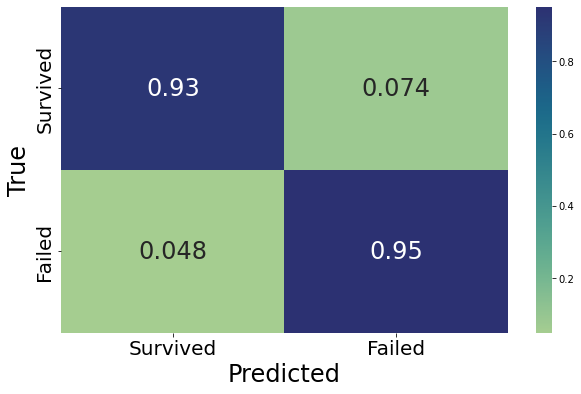

In [12]:
# constant for classes
classes = ('Survived', 'Failed')
plot_confusion(val_data, 'damage_state', 'damage_state_class_pred', classes)

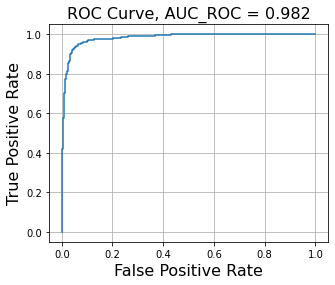

In [13]:
plot_auc_roc(val_data, 'damage_state', 'damage_state_pred')

,Survived,Failed
Survived,0.961144,0.038856
Failed,0.032316,0.967684


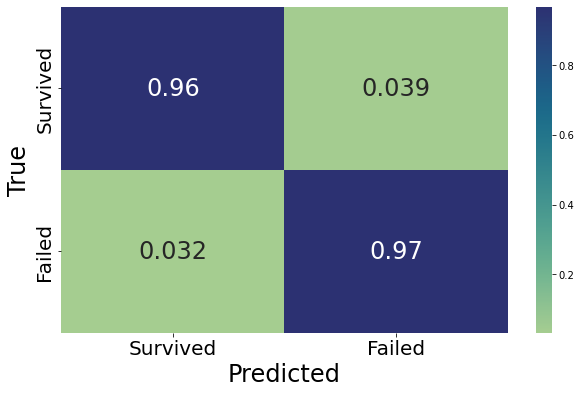

In [14]:
plot_confusion(train_data, 'damage_state', 'damage_state_class_pred', classes)

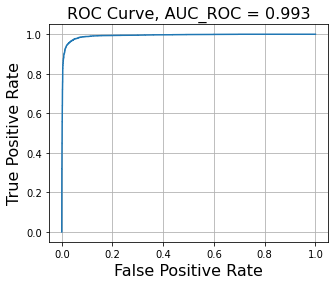

In [15]:
plot_auc_roc(train_data, 'damage_state', 'damage_state_pred')

In [16]:
accuracy_score(np.array(train_data['damage_state']), np.array(train_data['damage_state_class_pred']))

0.964

## Loss Evolution

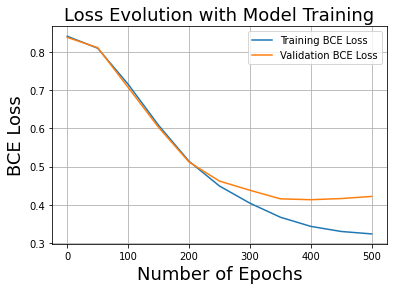

In [17]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(range(0, interval + max_epochs, interval), error_evolution_training, label = 'Training BCE Loss')
ax.plot(range(0, interval + max_epochs, interval), error_evolution_val, label = 'Validation BCE Loss')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("BCE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [18]:
y_pred_test = predict_metaimnet(model1, model2, x_th_test, x_test_scaled, test_data)

test_data['damage_state_pred'] = y_pred_test.detach().view(-1).numpy()
test_data['damage_state_class_pred'] = test_data['damage_state_pred'].round().astype("int")

## Confusion Matrix on Test Data

,Survived,Failed
Survived,0.929562,0.070438
Failed,0.061748,0.938252


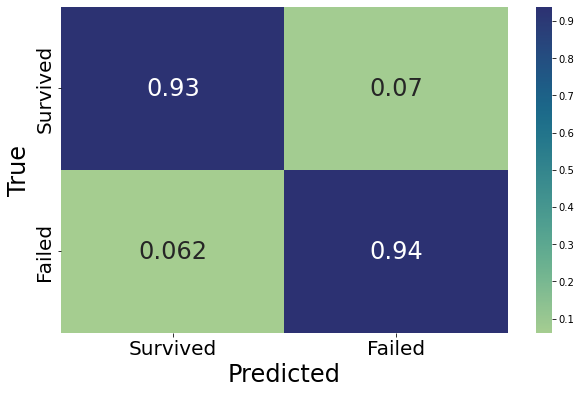

In [19]:
plot_confusion(test_data, 'damage_state', 'damage_state_class_pred', classes)

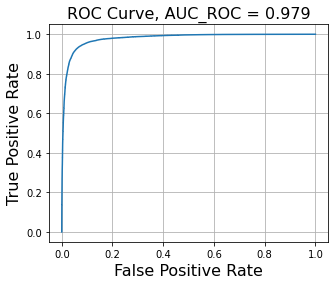

In [20]:
plot_auc_roc(test_data, 'damage_state', 'damage_state_pred')

In [21]:
accuracy_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9333157443440406

In [22]:
roc_auc_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_pred']))

0.9789293620577081

## Confusion Matrix on Combined Train, Validation, and Test Data

,Survived,Failed
Survived,0.932817,0.067183
Failed,0.058467,0.941533


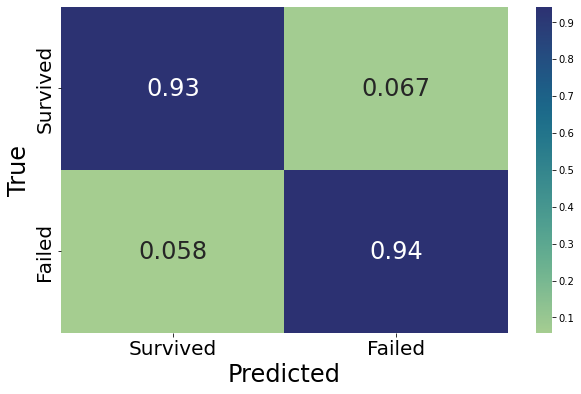

In [23]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_confusion(all_data, 'damage_state', 'damage_state_class_pred', classes)

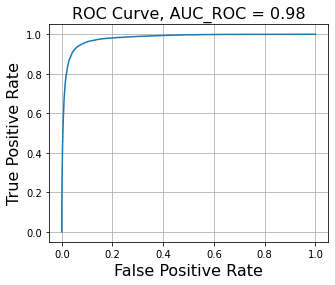

In [24]:
plot_auc_roc(all_data, 'damage_state', 'damage_state_pred')

In [25]:
# del train_data, val_data, test_data

## Compare Fragilities

In [26]:
fragility_df_high_fidelity = develop_fragility_model_stripe(predictors_all, 'pga', 'damage_state', bin_width = 0.1, max_im = 1.5)
fragility_df_pred = develop_fragility_model_stripe(all_data, 'pga', 'damage_state_class_pred', bin_width = 0.1, max_im = 1.5)

In [27]:
fragility_df_pred

,IM,Probability
0,0.05,0.0005
1,0.15,0.066508
2,0.25,0.197765
3,0.35,0.348262
4,0.45,0.469099
5,0.55,0.534915
6,0.65,0.582809
7,0.75,0.611424
8,0.85,0.648598
9,0.95,0.683655


In [28]:
fragility_df_high_fidelity

,IM,Probability
0,0.05,0.00225
1,0.15,0.080135
2,0.25,0.198895
3,0.35,0.339127
4,0.45,0.438068
5,0.55,0.500944
6,0.65,0.558351
7,0.75,0.592582
8,0.85,0.629641
9,0.95,0.655155


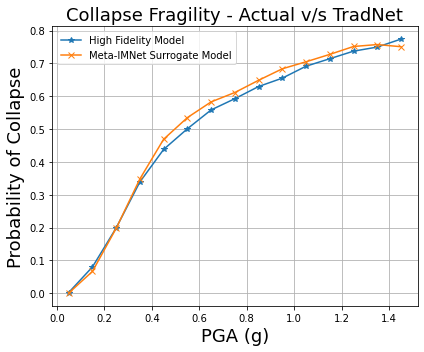

 Mean error = 0.019442, Max error = 0.033971


In [29]:
fig, ax = plt.subplots(1,1, figsize = (6, 5))

error_mean = (((fragility_df_high_fidelity['Probability'] - fragility_df_pred['Probability'])**2).mean())**0.5
error_max = (((fragility_df_high_fidelity['Probability'] - fragility_df_pred['Probability'])**2).max())**0.5

ax.plot(np.array(fragility_df_high_fidelity['IM']), np.array(fragility_df_high_fidelity['Probability']), '*-', label = 'High Fidelity Model')
ax.plot(np.array(fragility_df_pred['IM']), np.array(fragility_df_pred['Probability']), 'x-', label = 'Meta-IMNet Surrogate Model')
ax.legend()
ax.set_xlabel('PGA (g)', fontsize = 18)
ax.set_ylabel('Probability of Collapse', fontsize = 18)
ax.set_title('Collapse Fragility - Actual v/s TradNet', fontsize = 18)
ax.grid()

plt.tight_layout()
plt.show()

print(' Mean error = {}, Max error = {}'.format(round(error_mean,6), round(error_max,6)))

In [30]:
# fragility_df_pred.to_parquet('frag_df5_metanet_new.parquet', engine = 'pyarrow')